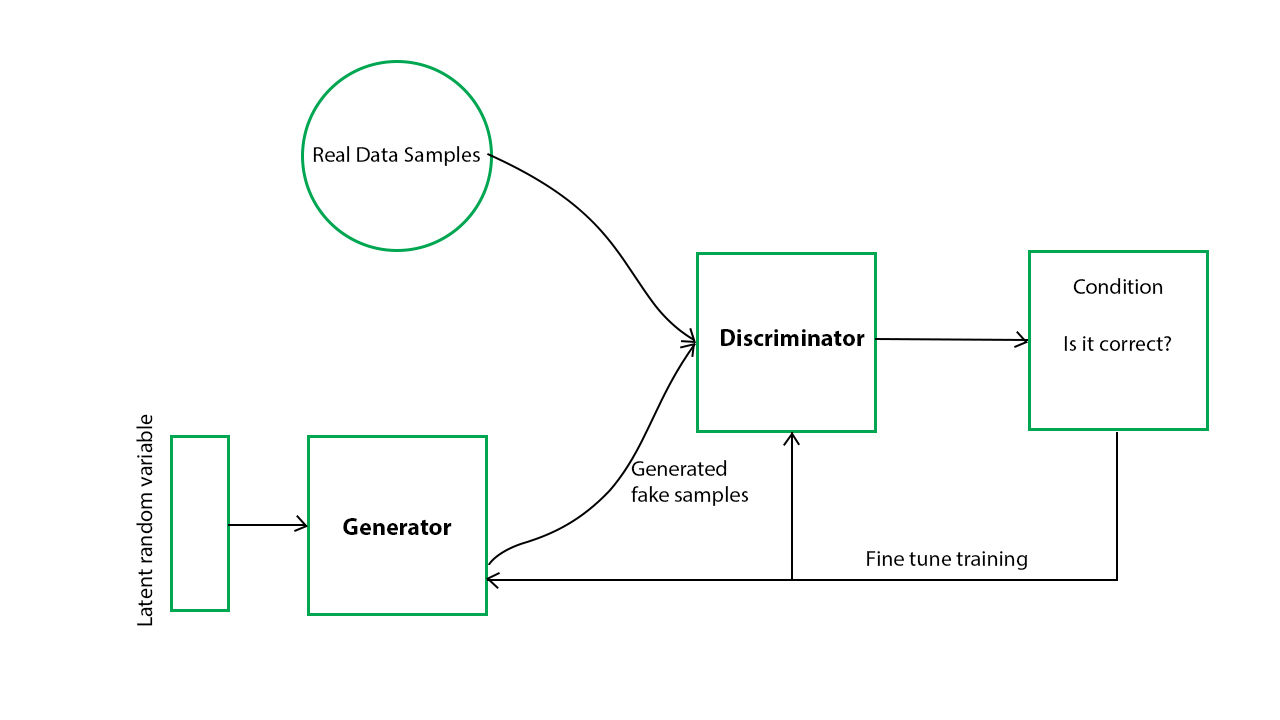

# Imports

In [2]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import rasterio

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)


# Data Preparation

In [38]:
import os
import numpy as np
import rasterio
import tensorflow as tf

def load_image(image_path):
    # Read the multispectral or panchromatic image using rasterio
    with rasterio.open(image_path) as src:
        image = src.read()  # Shape will be (bands, height, width)
    return image

def preprocess_images(ms_image, pan_image):
    # Normalize images (scale between 0 and 1)
    min_val = np.min(ms_image)
    max_val = np.max(ms_image)
    print(f'min ms {min_val}')
    print(f'max ms {max_val}')
    
    min_val = np.min(pan_image)
    max_val = np.max(pan_image)
    print(f'min pan {min_val}')
    print(f'max pan {max_val}')
    
    ms_image = ms_image.astype(np.float32) / 255.0  # MS image with multiple bands
    pan_image = pan_image.astype(np.float32) / 255.0  # PAN image with a single band
    
    # Transpose the MS image from (bands, height, width) to (height, width, bands)
    ms_image = np.transpose(ms_image, (1, 2, 0))  # Shape: (256, 256, 4)
    
    # Ensure the PAN image is 2D (remove unnecessary dimensions)
    if len(pan_image.shape) == 3 and pan_image.shape[0] == 1:
        pan_image = pan_image.squeeze(0)  # Remove the leading dimension if it's 1

    # Resize PAN image to match the MS image's height and width
    pan_image_resized = tf.image.resize(np.expand_dims(pan_image, axis=-1), 
                                        (ms_image.shape[0], ms_image.shape[1])).numpy()  # Shape: (256, 256, 1)
    
    
    return ms_image, pan_image_resized



# Load dataset (assuming directories with .tif images for multispectral and panchromatic)
ms_images_dir = '/kaggle/input/ikonos/ms'
pan_images_dir = '/kaggle/input/ikonos/pan'

ms_images = []
pan_images = []

for filename in os.listdir(ms_images_dir):
    ms_image = load_image(os.path.join(ms_images_dir, filename))
    pan_image = load_image(os.path.join(pan_images_dir, filename))
    
    ms_image, pan_image_resized = preprocess_images(ms_image, pan_image)
    
    ms_images.append(ms_image)
    pan_images.append(pan_image_resized)

ms_images = np.array(ms_images)  # Shape: (num_samples, bands, height, width)
pan_images = np.array(pan_images)  # Shape: (num_samples, height, width, 1)

# Train-validation split
from sklearn.model_selection import train_test_split
ms_train, ms_val, pan_train, pan_val = train_test_split(ms_images, pan_images, test_size=0.2, random_state=42)

# Check shapes
print(f"Training Multispectral Images Shape: {ms_train.shape}")
print(f"Training Panchromatic Images Shape: {pan_train.shape}")


min ms 46
max ms 2047
min pan 1
max pan 2047
min ms 73
max ms 1722
min pan 1
max pan 2047
min ms 308
max ms 647
min pan 317
max pan 614
min ms 280
max ms 1239
min pan 94
max pan 2022
min ms 242
max ms 1180
min pan 211
max pan 1916
min ms 91
max ms 791
min pan 87
max pan 821
min ms 179
max ms 843
min pan 201
max pan 1095
min ms 239
max ms 2038
min pan 15
max pan 2047
min ms 47
max ms 2047
min pan 1
max pan 2047
min ms 13
max ms 644
min pan 48
max pan 703
min ms 31
max ms 663
min pan 43
max pan 502
min ms 217
max ms 957
min pan 10
max pan 1799
min ms 68
max ms 1357
min pan 45
max pan 2047
min ms 161
max ms 630
min pan 169
max pan 944
min ms 125
max ms 1324
min pan 1
max pan 2047
min ms 202
max ms 2047
min pan 1
max pan 2047
min ms 183
max ms 1327
min pan 8
max pan 2047
min ms 192
max ms 1307
min pan 237
max pan 1110
min ms 169
max ms 926
min pan 161
max pan 1426
min ms 171
max ms 1381
min pan 1
max pan 1960
min ms 220
max ms 1769
min pan 164
max pan 2047
min ms 278
max ms 1269
min pan 29

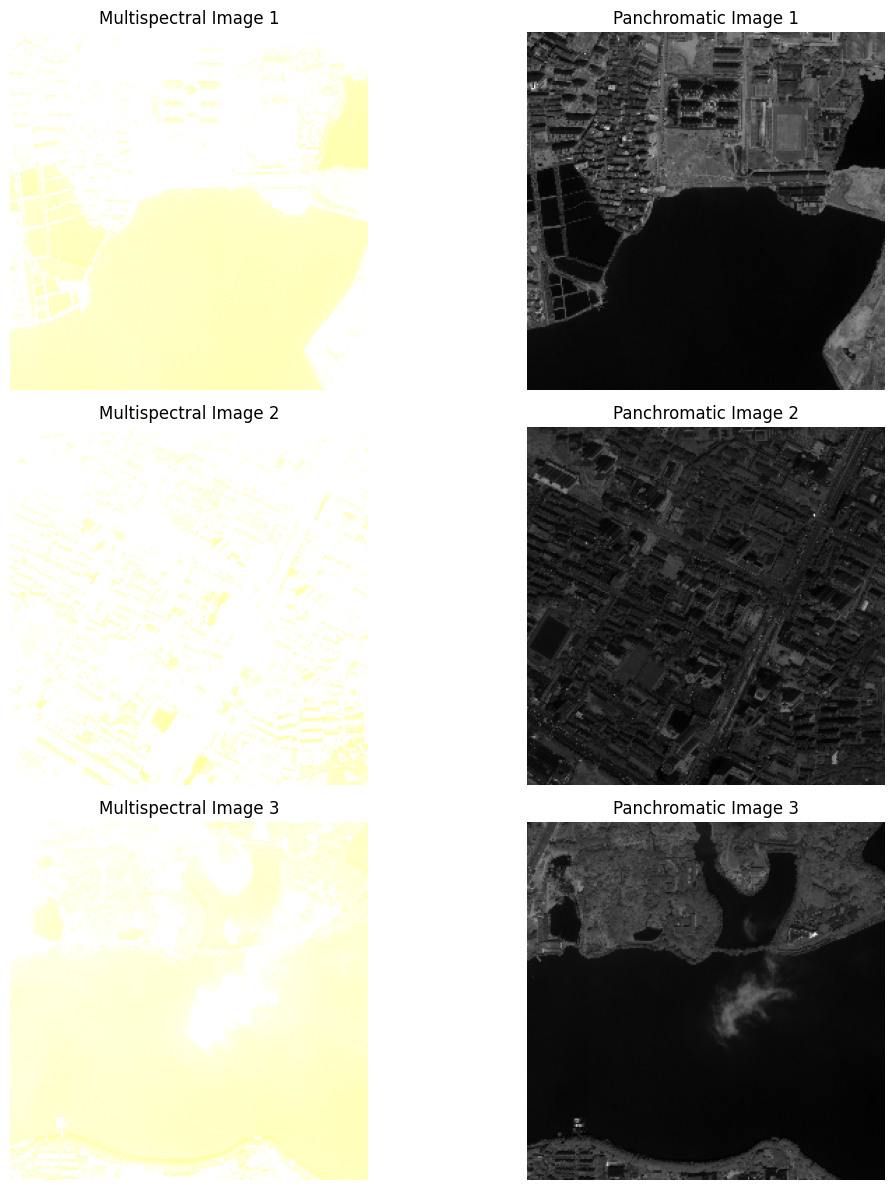

In [37]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_images(ms_images, pan_images, num_images=3):
    plt.figure(figsize=(12, num_images * 4))
    
    for i in range(num_images):
        # Multispectral image (MS) visualization (use correct RGB bands: Red: Band 3, Green: Band 2, Blue: Band 1)
        plt.subplot(num_images, 2, 2 * i + 1)
        rgb_image = ms_images[i][:, :, [0, 1, 2]]  # Red: Band 3, Green: Band 2, Blue: Band 1
        plt.imshow(np.clip(rgb_image, 0, 1))  # Ensure values are between 0 and 1 for visualization
        plt.title(f'Multispectral Image {i+1}')
        plt.axis('off')

        # Panchromatic image (PAN) visualization
        plt.subplot(num_images, 2, 2 * i + 2)
        plt.imshow(pan_images[i].squeeze(), cmap='gray')
        plt.title(f'Panchromatic Image {i+1}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize 3 images from the training set
visualize_images(ms_train, pan_train, num_images=3)


# Building pix2pix Model

## Generator

In [5]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))
    
    if apply_batchnorm:
        result.add(layers.BatchNormalization())
    
    result.add(layers.LeakyReLU())
    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))
    result.add(layers.BatchNormalization())
    
    if apply_dropout:
        result.add(layers.Dropout(0.5))
    
    result.add(layers.ReLU())
    return result

def build_generator():
    inputs = layers.Input(shape=[None, None, 5])  # 4-channel MS + 1-channel PAN

    down_stack = [
        downsample(64, 4, apply_batchnorm=False),  # (bs, 128, 128, 64)
        downsample(128, 4),  # (bs, 64, 64, 128)
        downsample(256, 4),  # (bs, 32, 32, 256)
        downsample(512, 4),  # (bs, 16, 16, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),  # (bs, 32, 32, 512)
        upsample(256, 4),  # (bs, 64, 64, 256)
        upsample(128, 4),  # (bs, 128, 128, 128)
        upsample(64, 4),  # (bs, 256, 256, 64)
    ]
    
    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(4, 4, strides=2, padding='same', kernel_initializer=initializer, activation='tanh')  # Final output layer for MS
    
    x = inputs
    skips = []
    
    # Downsampling through the model
    for down in down_stack:
        x = down(x)
        skips.append(x)
    
    skips = reversed(skips[:-1])
    
    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])
    
    x = last(x)
    
    return tf.keras.Model(inputs=inputs, outputs=x)


## Discriminator

In [6]:
def build_discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    
    input_ms = layers.Input(shape=[None, None, 4], name='input_multispectral')
    input_pan = layers.Input(shape=[None, None, 1], name='input_panchromatic')
    
    x = layers.concatenate([input_ms, input_pan])
    
    down1 = downsample(64, 4, False)(x)
    down2 = downsample(128, 4)(down1)
    down3 = downsample(256, 4)(down2)
    
    zero_pad1 = layers.ZeroPadding2D()(down3)
    conv = layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(zero_pad1)
    batchnorm1 = layers.BatchNormalization()(conv)
    leaky_relu = layers.LeakyReLU()(batchnorm1)
    
    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)
    last = layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2)
    
    return tf.keras.Model(inputs=[input_ms, input_pan], outputs=last)


# Define Loosses

In [7]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = loss_obj(tf.ones_like(real_output), real_output)
    fake_loss = loss_obj(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output, gen_output, target):
    gan_loss = loss_obj(tf.ones_like(fake_output), fake_output)
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_gen_loss = gan_loss + (100 * l1_loss)  # Lambda = 100
    return total_gen_loss



# Build the model

In [8]:
generator = build_generator()
discriminator = build_discriminator()

generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# Training

In [9]:
EPOCHS = 20
BUFFER_SIZE = 400
BATCH_SIZE = 1

def train_step(ms_image, pan_image, target):
    # The PAN image is already resized during preprocessing, so no further resize is needed
    
   
    # Concatenate the MS (4 channels) and PAN (1 channel) images along the channel axis
    input_image = tf.concat([ms_image, pan_image], axis=-1)  # Should be 5 channels in total
    


    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generator's forward pass
        gen_output = generator(input_image, training=True)

        # Discriminator's forward pass for real and generated images
        disc_real_output = discriminator([target, pan_image], training=True)
        disc_generated_output = discriminator([gen_output, pan_image], training=True)

        # Compute generator and discriminator losses
        gen_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    # Compute and apply gradients for generator and discriminator
    generator_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))


from tqdm import tqdm

def train(dataset, epochs):
    for epoch in range(epochs):
        # Create a progress bar for the current epoch
        progress_bar = tqdm(enumerate(dataset), total=len(dataset), desc=f"Epoch {epoch+1}/{epochs}")
        
        for batch_index, (ms_image, pan_image, target) in progress_bar:
            # Perform a training step
            train_step(ms_image, pan_image, target)
            
            # Optionally, update progress bar with custom metrics like loss
            # progress_bar.set_postfix({"loss": current_loss})

        print(f"Epoch {epoch+1}/{epochs} completed")


# Create a TensorFlow dataset and batch the data
train_dataset = tf.data.Dataset.from_tensor_slices((ms_train, pan_train, ms_train)).batch(BATCH_SIZE)
train(train_dataset, EPOCHS)


Epoch 1/20: 100%|██████████| 160/160 [01:01<00:00,  2.59it/s]


Epoch 1/20 completed


Epoch 2/20: 100%|██████████| 160/160 [00:55<00:00,  2.87it/s]


Epoch 2/20 completed


Epoch 3/20: 100%|██████████| 160/160 [00:56<00:00,  2.85it/s]


Epoch 3/20 completed


Epoch 4/20: 100%|██████████| 160/160 [00:55<00:00,  2.86it/s]


Epoch 4/20 completed


Epoch 5/20: 100%|██████████| 160/160 [00:56<00:00,  2.86it/s]


Epoch 5/20 completed


Epoch 6/20: 100%|██████████| 160/160 [00:56<00:00,  2.84it/s]


Epoch 6/20 completed


Epoch 7/20: 100%|██████████| 160/160 [00:56<00:00,  2.85it/s]


Epoch 7/20 completed


Epoch 8/20: 100%|██████████| 160/160 [00:56<00:00,  2.84it/s]


Epoch 8/20 completed


Epoch 11/20: 100%|██████████| 160/160 [00:56<00:00,  2.85it/s]


Epoch 11/20 completed


Epoch 12/20: 100%|██████████| 160/160 [00:56<00:00,  2.84it/s]


Epoch 12/20 completed


Epoch 13/20: 100%|██████████| 160/160 [01:22<00:00,  1.95it/s]


Epoch 13/20 completed


Epoch 14/20: 100%|██████████| 160/160 [00:56<00:00,  2.86it/s]


Epoch 14/20 completed


Epoch 15/20: 100%|██████████| 160/160 [00:56<00:00,  2.85it/s]


Epoch 15/20 completed


Epoch 17/20: 100%|██████████| 160/160 [00:56<00:00,  2.84it/s]


Epoch 17/20 completed


Epoch 18/20: 100%|██████████| 160/160 [00:56<00:00,  2.86it/s]


Epoch 18/20 completed


Epoch 19/20: 100%|██████████| 160/160 [01:22<00:00,  1.95it/s]


Epoch 19/20 completed


Epoch 20/20: 100%|██████████| 160/160 [00:56<00:00,  2.84it/s]

Epoch 20/20 completed


# Evaluation and Visualization

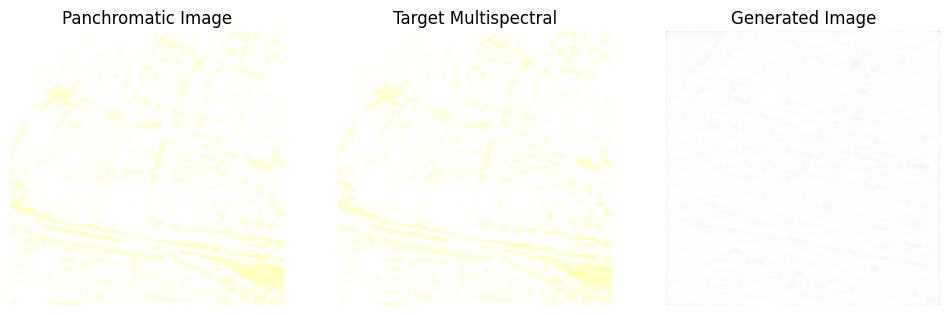

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import cv2  # For saving the image

def visualize_image(sample_ms, sample_pan, target_ms, output_path='generated_image.png'):
    # Concatenate multispectral and panchromatic images along the channel axis
    input_image = tf.concat([sample_ms, sample_pan], axis=-1)
    
    # Generate the output using the concatenated input
    generated_image = generator(input_image, training=False)

    plt.figure(figsize=(12, 12))
    display_list = [sample_pan[0], target_ms[0], generated_image]
    title = ['Panchromatic Image', 'Target Multispectral', 'Generated Image']

    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(title[i])
        img = display_list[i]
        
        if hasattr(img, 'numpy'):
            img = img.numpy().squeeze()
        else:
            img = img.squeeze()
        
        plt.imshow(img, cmap='gray' if i == 0 else None)
        plt.axis('off')

    plt.show()

    # Save the generated image as high-resolution RGB
    generated_image_rgb = generated_image.numpy().squeeze()  # Convert to NumPy array
    if generated_image_rgb.shape[-1] == 1:  # If it's grayscale
        generated_image_rgb = np.repeat(generated_image_rgb, 3, axis=-1)  # Convert to RGB

    # Ensure the output image is in the range [0, 255]
    generated_image_rgb = (generated_image_rgb * 255).astype(np.uint8)

    # Save the image using OpenCV
    cv2.imwrite(output_path, generated_image_rgb)

# Test the updated visualization
visualize_image(pan_val[0:1], ms_val[0:1], ms_val[0:1])
